# DenseNet121 
In this notebook we build DenseNet121 and use it for binary image classification. The data are X-Ray images that contain 2 classes `Normal` and `Pneumonia`. The data are available in this [link](https://drive.google.com/drive/folders/1yZoXee6uN7cLmSfh5pDMJtecUiwqig7I?usp=sharing)

This is the link to this notebook: https://colab.research.google.com/drive/1M8ludkMwiNN7wJxRQfquzcu9aFO1yl71?usp=sharing 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.layers import ReLU, concatenate
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D
import tensorflow.keras.backend as K
#from tensorflow.python.keras.layers import wrappers
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz
import cv2
import os

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17271903163815595038
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15179727289318965024
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Data loading and preprocessing
* Load data from Google Drive
* Define function to return the image and it's label
* Load images from directory and perform slight preprocessing and batching
* Split the training set into train/validation sets
* Perform data augmentation
* Load test set **without** data augmentation
* Get and plot the number of classes and their data

Since there is class imbalance we adjust the weights of each class to make them equally important

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def process_img(img, label):
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return img, label

train_ds = image_dataset_from_directory(
    'drive/My Drive/chest_xray/train',
    labels='inferred',
    shuffle=True,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

test_ds = image_dataset_from_directory(
    'drive/My Drive/chest_xray/test',
    labels='inferred',
    shuffle=False,
    batch_size=64,
    image_size=(256,256),
    color_mode='grayscale',
    label_mode='binary',
    interpolation='nearest'
).map(process_img)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  rotation_range = 30,
                                                                  vertical_flip=True,
                                                                  validation_split=0.20)

train_data_gen = image_generator.flow_from_directory(directory='drive/My Drive/chest_xray/train',
                                                     target_size=(256, 256),
                                                     color_mode="grayscale",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     subset='training')


val_data_gen = image_generator.flow_from_directory(directory='drive/My Drive/chest_xray/train',
                                                     target_size=(256, 256),
                                                     color_mode="grayscale",
                                                     class_mode='binary',
                                                     batch_size=32,
                                                     shuffle=False,
                                                     subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
image_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_gen = image_generator2.flow_from_directory(directory='drive/My Drive/chest_xray/test', 
                                                    target_size=(256, 256),
                                                    color_mode="grayscale",
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    shuffle=False)

Found 624 images belonging to 2 classes.


In [ ]:
filenames = tf.io.gfile.glob(str('drive/My Drive/chest_xray/train/*/*'))

Normal = len([filenames for filename in filenames   if "NORMAL" in filename])
print("Normal images count in training set: " + str(Normal))

Pneumonia = len([filenames for filename in filenames   if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(Pneumonia))


Normal images count in training set: 1341
Pneumonia images count in training set: 3875


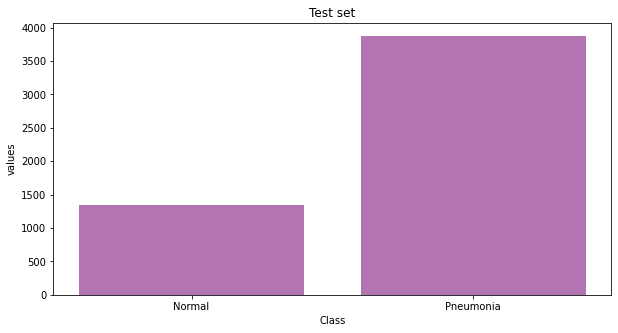

In [ ]:
plt.figure(figsize=(10,5))

# create dataset
height = [Normal, Pneumonia]
bars = ('Normal', 'Pneumonia')

 
# Create bars and choose color
plt.bar(bars, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Test set')
plt.xlabel('Class')
plt.ylabel('values')
 
# Show graph
plt.show()

In [ ]:
weight_Normal = (1 / Normal)*(4173)/2.0 
weight_Pneumonia = (1 / Pneumonia)*(4173)/2.0

class_weight = {0: weight_Normal, 1: weight_Pneumonia}

print('Weight for Normal: {:.2f}'.format(weight_Normal))
print('Weight for Pneumonia: {:.2f}'.format(weight_Pneumonia))

Weight for Normal: 1.56
Weight for Pneumonia: 0.54


## Creating DenseNet

DenseNet (Dense Convolutional Network) is an architecture that focuses on making the deep learning networks go even deeper, but at the same time making them more efficient to train, by using shorter connections between the layers. DenseNet is a convolutional neural network where each layer is connected to all other layers that are deeper in the network. This is done to enable maximum information flow between the layers of the network. To preserve the feed-forward nature, each layer obtains inputs from all the previous layers and passes on its own feature maps to all the layers which will come after it.

DenseNet consists of two important blocks other than the basic convolutional and pooling layers:
* The Dense Blocks 
* The Transition layers

In [ ]:
#Build the model
def densenet(input_shape, n_classes, filters = 32):
    
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'sigmoid')(x)
    
    model = Model(input, output)
    return model

This is the architecture of the DenseNet

In [ ]:
model = densenet((256,256,1) , 1)
#model.summary()

In [ ]:
#Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop() , loss = 'binary_crossentropy' , metrics = ['accuracy'])

This code helps visualise the DenseNet

In [ ]:
'''
SVG(model_to_dot
    (model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60, subgraph=False
).create(prog='dot',format='svg'))
'''

"\nSVG(model_to_dot\n    (model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60, subgraph=False\n).create(prog='dot',format='svg'))\n"

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.2, min_lr=0.00001)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7,restore_best_weights=True)

In [ ]:
#Fit the model
history = model.fit(
    train_data_gen,
    batch_size = 32,
    epochs = 50 , 
    validation_data = val_data_gen,
    class_weight = class_weight,
    callbacks = [learning_rate_reduction, early_stopping_cb])

Epoch 1/50
131/131 [==============================] - 605s 4s/step - loss: 0.6661 - accuracy: 0.7757 - val_loss: 0.6758 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 2/50
131/131 [==============================] - 93s 706ms/step - loss: 0.2840 - accuracy: 0.8648 - val_loss: 3.8965 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 3/50
131/131 [==============================] - 92s 704ms/step - loss: 0.2229 - accuracy: 0.8862 - val_loss: 4.1632 - val_accuracy: 0.4573 - lr: 0.0010
Epoch 4/50
131/131 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9017
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 [==============================] - 94s 712ms/step - loss: 0.1990 - accuracy: 0.9017 - val_loss: 1.9646 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 5/50
131/131 [==============================] - 93s 707ms/step - loss: 0.1598 - accuracy: 0.9156 - val_loss: 0.4896 - val_accuracy: 0.7843 - lr: 2.0000e-04
Epoch 6/50
131/131 [==========================

## Plot the results

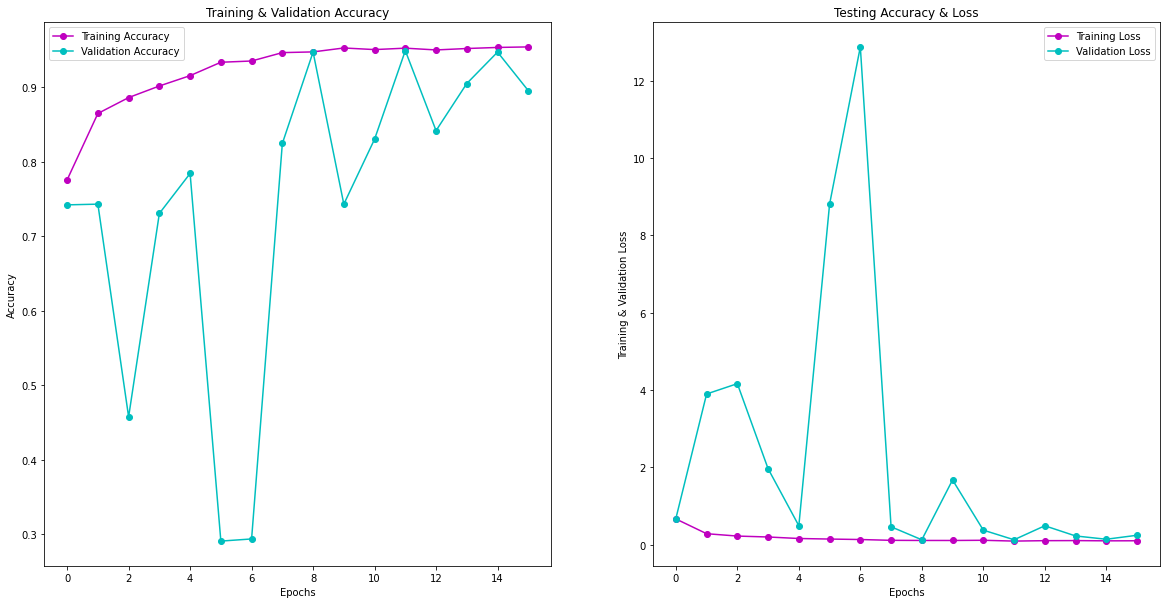

In [ ]:
epochs = [i for i in range(16)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'mo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'co-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'm-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'c-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")


plt.show()

## Evaluate the model
* Evaluate and make predictions with the test set
* Plot the confusion matrix
* Compute the performance metrics|

In [ ]:
# Evaluate
test_loss , test_accuracy = model.evaluate(test_data_gen)

20/20 [==============================] - 143s 7s/step - loss: 0.3407 - accuracy: 0.8542


In [ ]:
# Make predictions 
predictions = model.predict(test_data_gen)

#predictions = predictions.reshape(1,-1)[0]
predictions = predictions.round()

y_test = test_data_gen.classes


print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.90      0.69      0.78       234
Pneumonia (Class 1)       0.84      0.95      0.89       390

           accuracy                           0.85       624
          macro avg       0.87      0.82      0.84       624
       weighted avg       0.86      0.85      0.85       624



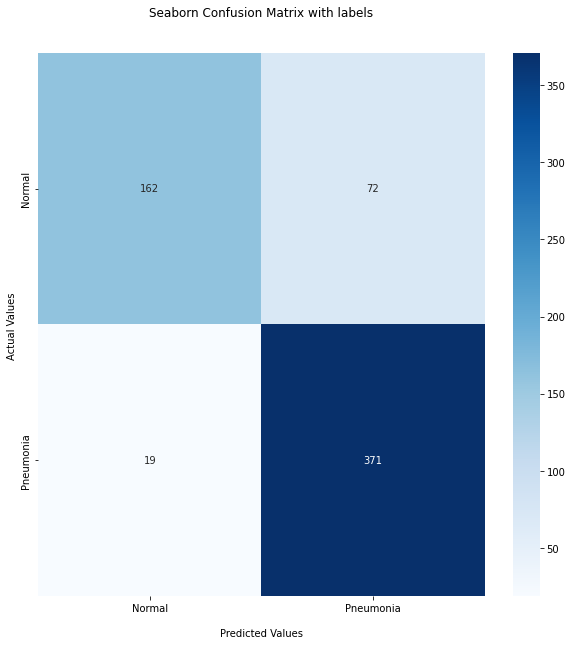

In [ ]:
# Plot confusion matrix
plt.figure(figsize = (10,10))

cm = confusion_matrix(y_test,predictions)

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Recall of the model is 0.95
Precision of the model is 0.84
F1 Score of the model is 0.89
